In [1]:
# In this notebooks we examine how the morphology of storm systems 
# impacts its extremal precipitation
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.pf_stats import *
from src.plotting import *
from src.regions import *

In [2]:
CORE_THRESH = 5

regions = [
    cio_region(), 
    wmp_region(),
]

pf_stats = pd.concat(
    [load_pf_stats(r, maxpr_min=CORE_THRESH) for r in regions]
)

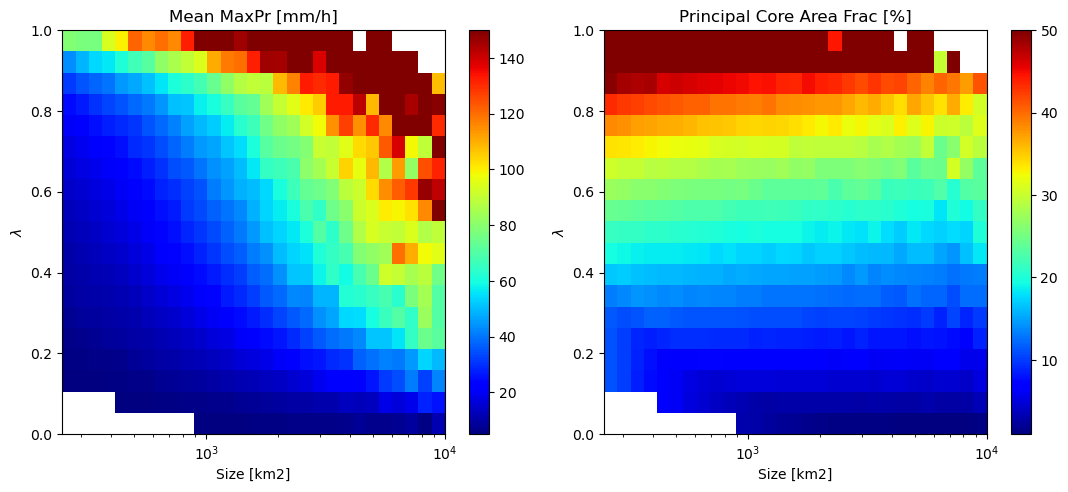

In [3]:
fig, axs = plt.subplots(
    ncols=2, 
    figsize=(11, 5)
)


area = pf_stats['num_pixels'] * 30
area_bins = np.logspace(np.log10(250), 4, 30)

loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
loc_bins = np.linspace(0, 1, 20)

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

maxpr = pf_stats['max_precip']
core_area_frac = 100 * pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_size_8conn']/pf_stats['num_pixels']

for axi, ax in enumerate(axs.ravel()):
    match axi:
        case 0:
            stat = binned_statistic_2d(
                loc, 
                area, 
                maxpr, 
                bins=[loc_bins, area_bins], 
                statistic=np.nanmean
            ).statistic
            cmap = plt.cm.jet
            norm=colors.Normalize(vmin=5, vmax=150)
            x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
            title= 'Mean MaxPr [mm/h]'


        case 1:
            stat = binned_statistic_2d(
                loc, 
                area, 
                core_area_frac, 
                bins=[loc_bins, area_bins], 
                statistic=np.nanmean
            ).statistic
            cmap = plt.cm.jet
            norm=colors.Normalize(vmin=1, vmax=50)
            x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
            title= 'Principal Core Area Frac [%]'    

    
    # Plot the stat
    c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        stat, 
        cmap=cmap,
        norm=norm
    )

    ax.set_xscale('log')
    ax.set_xlabel('Size [km2]')
    ax.set_ylabel(r'$\lambda$')
    ax.set_title(title)
    fig.colorbar(c)


fig.tight_layout(pad=1)


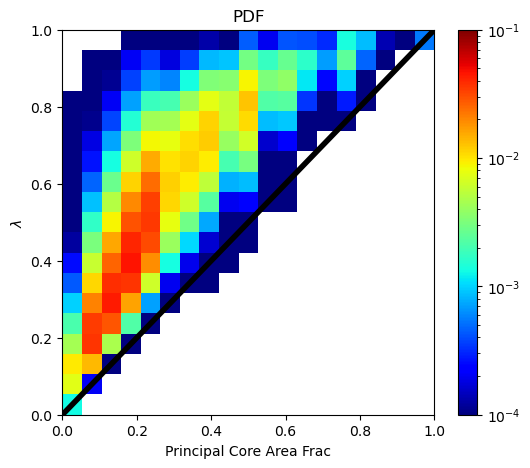

In [12]:
fig, ax = plt.subplots(
    figsize=(6, 5)
)

loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
core_area_frac = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_size_8conn']/pf_stats['num_pixels']
loc_bins = np.linspace(0, 1, 20)

x_mesh, y_mesh = np.meshgrid(loc_bins, loc_bins)

stat = binned_statistic_2d(
    loc, 
    core_area_frac, 
    None, 
    bins=[loc_bins, loc_bins], 
    statistic='count'
).statistic

pdf = stat/stat.sum()

c = ax.pcolormesh(
    x_mesh, 
    y_mesh, 
    pdf, 
    cmap=plt.cm.jet,
    norm=colors.LogNorm(vmin=1e-4, vmax=1e-1)
)
ax.plot([0,1], [0,1], color='k', lw=4)
ax.set_xlabel('Principal Core Area Frac')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PDF')
fig.colorbar(c)